# Network Creation

In [1]:
!pip install torch ./Gym-Wordle

Defaulting to user installation because normal site-packages is not writeable
Processing ./Gym-Wordle
  Created wheel for gym-wordle: filename=gym_wordle-0.1.3-py3-none-any.whl size=100034 sha256=668e720ad8cd9ce637c9f2af8f5858a633b2a01a530399926ac9405d79b6cc74
  Stored in directory: /user/jbreindl/.cache/pip/wheels/0d/2e/81/517ba7ac1c380991dcfb356e28b3f91d7064d3e7f18cf3c521
Successfully built gym-wordle
  Attempting uninstall: gym-wordle
    Found existing installation: gym-wordle 0.1.3
    Uninstalling gym-wordle-0.1.3:
      Successfully uninstalled gym-wordle-0.1.3


In [2]:
import torch
import matplotlib.pyplot as plt
from torch import normal

In [3]:
from torch import nn

class ActorNetwork(nn.Module):
    """LSTM RNN for generating words for wordle solver"""
    def __init__(self, input_size, output_size=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            #nn.Linear(32, 32),
            #nn.ReLU(),
            nn.Linear(32, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.network(x)
        return y

class CriticNet(nn.Module):
    """Network representing the critic"""
    def __init__(self, in_shape):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
            )

    def forward(self, x):
        return self.network(x)

# Figuring out the environment

In [4]:
import gym
import gym_wordle.utils
import numpy as np
wordle = gym.make('Wordle-v0')

# Use entropy minimization for reward function

In [5]:
def entropy_critic(guess: np.ndarray, remaining_space: np.ndarray):
    # get guess and the values
    orig_space = remaining_space.shape[0]
    split = np.split(guess, 2)
    g = split[0]
    vals = split[1]
    explored = set()

    # get complete matches (i.e. matches based on position)
    matches = np.argwhere(vals==1).flatten()
    for i in matches:
        remaining_space = remaining_space[np.nonzero(remaining_space[:, i] == g[i])] 
        explored.add(g[i])

    # find remaining words that this letter
    exists = np.argwhere(vals==2).flatten()
    for i in exists:
        if g[i] in explored:
            continue
        else:
            explored.add(g[i])
        e = np.full(remaining_space.shape[0], False)
        for j in range(5):
            if i == j or np.isin(j, matches):
                continue
            e = np.logical_or(e, remaining_space[:, j] == g[i])
        remaining_space = remaining_space[e]

    # we know what letters we DON'T have
    dne = np.argwhere(vals==3).flatten()
    for i in dne:
        if g[i] in explored:
            continue
        else:
            explored.add(g[i])
        e = np.full(remaining_space.shape[0], False)
        for j in range(5):
            if np.isin(j, matches):
                continue
            e = np.logical_or(e, remaining_space[:, j] == g[i])
        remaining_space = remaining_space[np.logical_not(e)]

    # do calc
    p = float(remaining_space.shape[0]) / float(orig_space)
    entropy = -np.log2(p)
    return entropy, remaining_space

# A2C solver

In [6]:
class Advantage_ActorCritic():
    def __init__(self, world: gym.Env, policy_net: ActorNetwork, critic,
                 encoder, policy_alpha,  gamma, max_reward):
        # environment info
        self.world = world
        self.encoder = encoder
        self.max_reward = max_reward

        # actor and critic
        self.actor = policy_net
        self.critic = critic
        self.error_buffer = list()
        self.policy_optimizer = torch.optim.Adam(policy_net.network.parameters(),
                                                 lr=policy_alpha, maximize=True)

        # training info
        self.gamma = gamma
        self.episodes = 0
        self.step = 0
        self.guesses = np.zeros(world.action_space.n)
        self.remaining = None

    def train(self, iterations):
        converged = False
        rewards = list()
        recents = torch.zeros(10)
        i = 0
        while not converged:
            r = self.episode()
            rewards.append(r)
            
            if i < 10:
                recents[i] = r

            else:
                recents.roll(-1, 0)
                recents[9] = r
            i += 1
            # convergence check
            if len(rewards) > 10 and recents.mean() >= self.max_reward:
                converged = True
            converged = True if iterations == i else False
        
        plt.plot(rewards)
        plt.show()

    def episode(self, training=True):
        done = False
        state = self.world.reset().copy()
        episode_reward = 0
        self.episodes += 1
        self.step = -1
        self.remaining = gym_wordle.utils.get_words("solution")
        while not done:
            self.step += 1
            # take on policy action
            encoded = self.encoder(state)
            dist = self.actor(encoded.flatten())

            action = normal(dist[0], dist[1])
            #action *= 2000
            action = int(action.clip(0, self.world.action_space.n-1).round().item())
            self.guesses[action] += 1
            state_prime, reward, done, _ = self.world.step(action)

            # fill buffer
            self.error_buffer.append((state, state_prime, reward, dist))

            # prepare for next iteration
            episode_reward += reward
            state = state_prime.copy()
            if training:
                self.__net_update()

        return episode_reward

    # Actor error
    def policy_error(self, prob, error):
        log_probabs_tensor = prob.reshape(-1)
        return (-log_probabs_tensor * error).mean()

    def __net_update(self):
        # calculate error for policy and critic
        self.actor.network.zero_grad()

        state, state_prime, reward, prob = self.error_buffer.pop(0)
        loss1 = self.critic(state[self.step-1], self.remaining)
        loss2, self.remaining = self.critic(state_prime[self.step], self.remaining)
        policy_error = self.policy_error(prob, loss2-1)

        # backprop
        policy_error.backward()
        #nn.utils.clip_grad_norm_(self.actor.parameters(), 1e-2)
        self.policy_optimizer.step()

# Solving the Environment

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
critic = entropy_critic
actor = ActorNetwork(60, 2).to(device)
state = torch.load('long_train.pt')
actor.load_state_dict(state)
agent = Advantage_ActorCritic(wordle, actor, critic, 
lambda x: torch.tensor(x.flatten()).to(torch.float32).to(device),
                              1e-6, 0.9, -4)

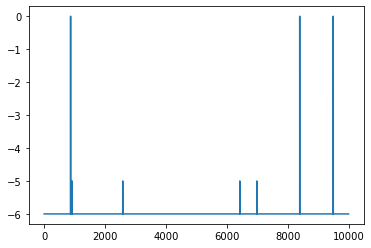

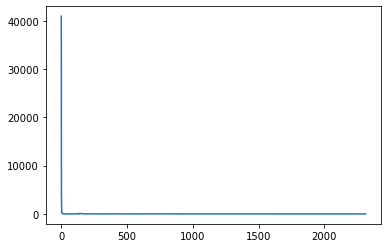

ABACK
ABASE
ABASE
ASSET
HENCE
PASTA


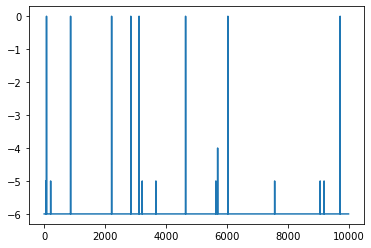

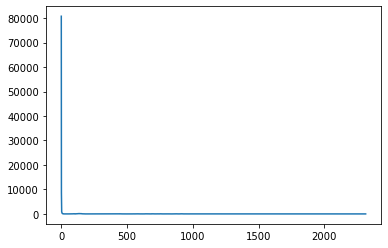

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


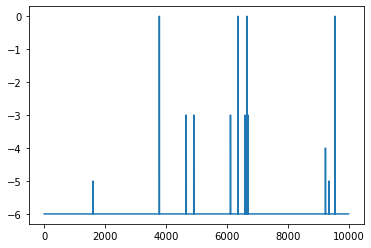

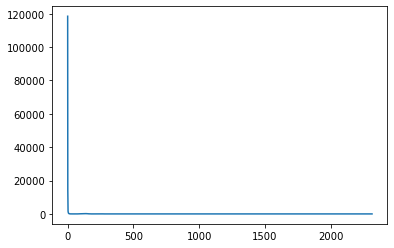

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


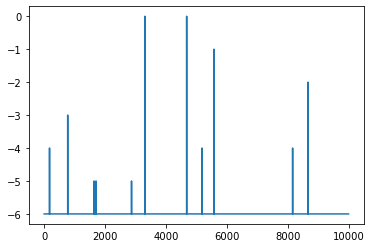

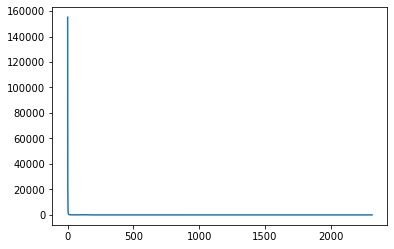

ABACK
ABASE
ABACK
ABASE
BASTE
DRESS


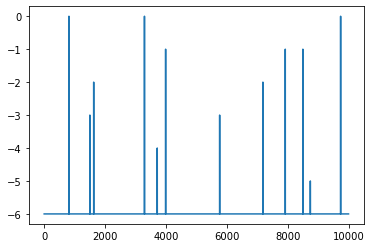

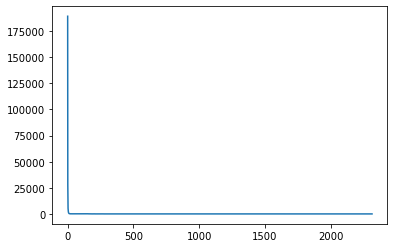

ABACK
ABACK
ABACK
ABACK
ABHOR
ABACK


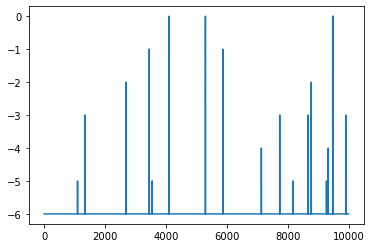

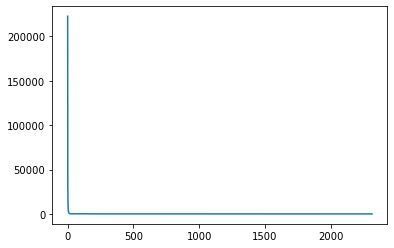

ABACK
ABACK
ABACK
ABACK
ABACK
ABUSE


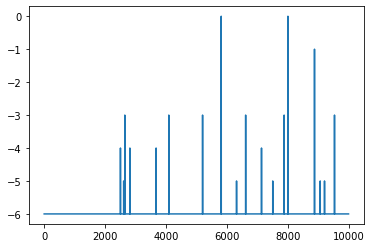

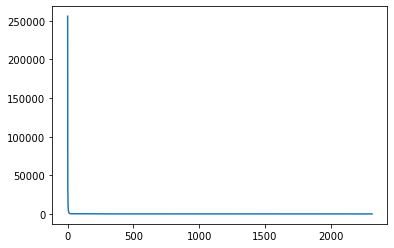

ABACK
ABATE
ABHOR
ACUTE
DUTCH
ORGAN


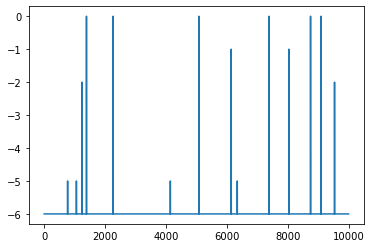

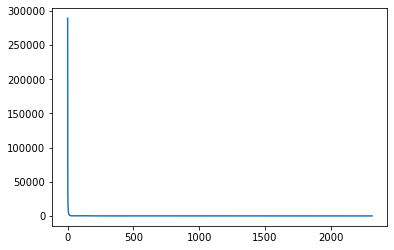

ABACK
ABACK
ABORT
ABHOR
BATHE
DEBUT


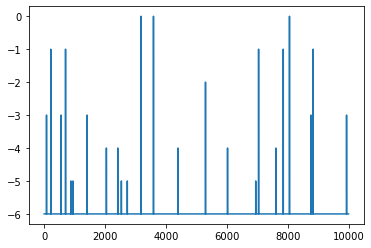

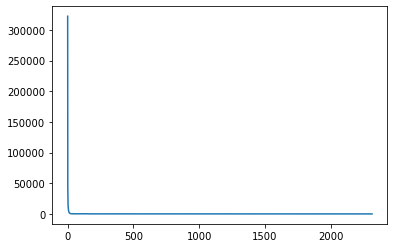

ABACK
ABATE
ABOUT
AWAIT
DROWN
MOTOR


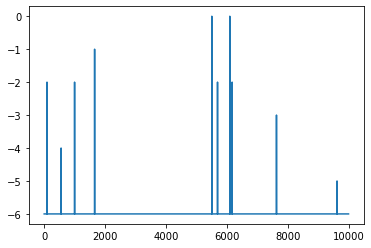

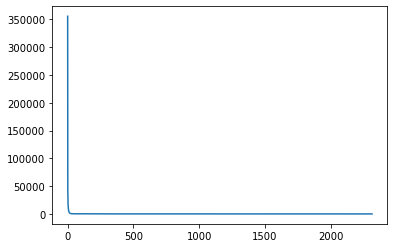

ABACK
ABLED
ABACK
ABACK
ABACK
ABACK


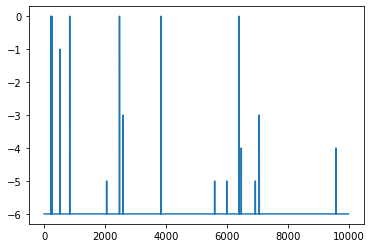

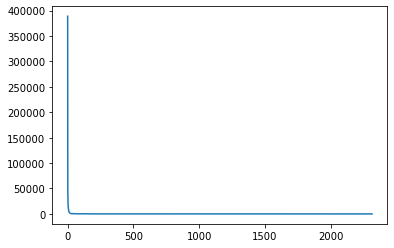

ABACK
ABODE
ABACK
ABACK
ABACK
ABACK


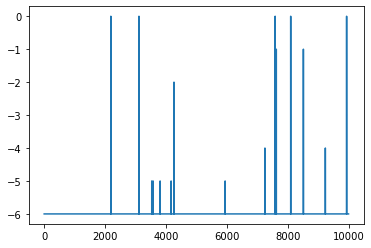

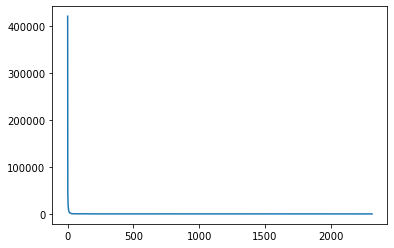

ABACK
ABHOR
ADAGE
ABACK
ABACK
ABACK


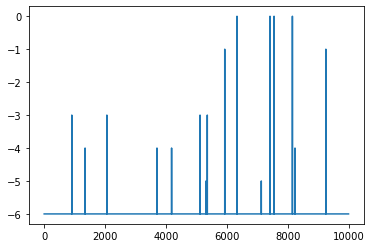

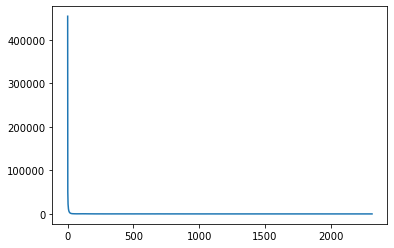

ABACK
ABACK
ABACK
ABODE
ADEPT
ABYSS


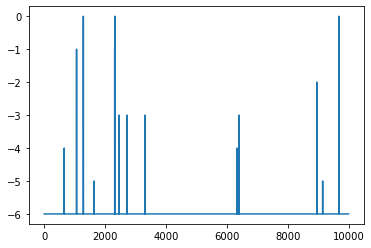

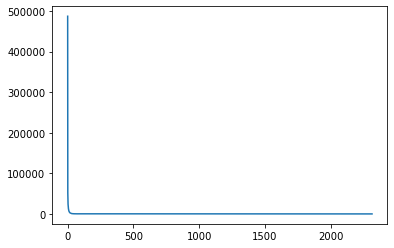

ABACK
ABACK
ABACK
ABACK
ADORN
ALONE


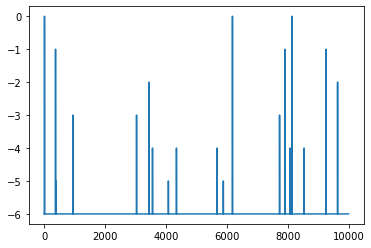

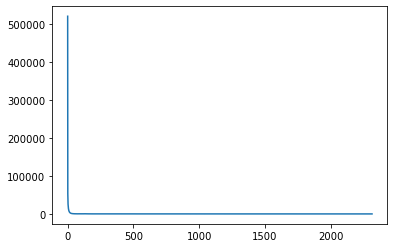

ABACK
ABACK
ABACK
ADEPT
ABODE
AFTER


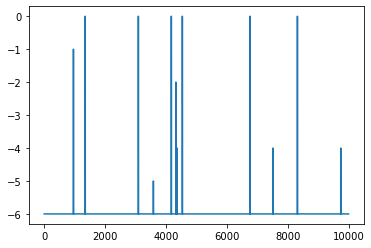

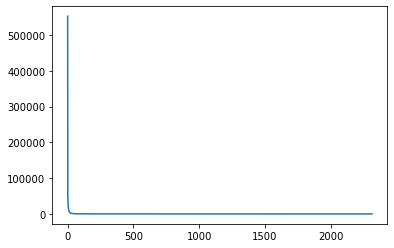

ABACK
ABACK
ABACK
ABACK
ADMIT
ABACK


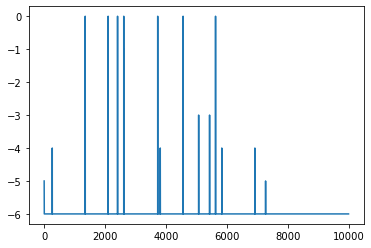

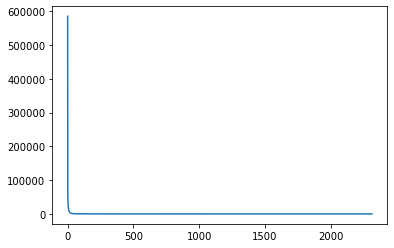

ABACK
ABACK
ACUTE
ABASE
ABACK
APRON


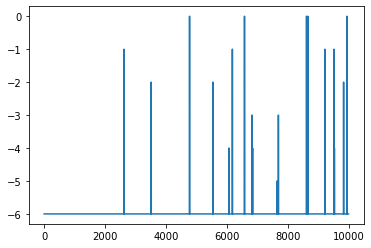

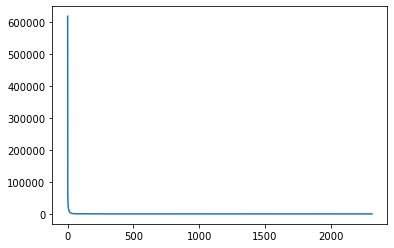

ABACK
ABBEY
ABACK
ABACK
ABACK
ABACK


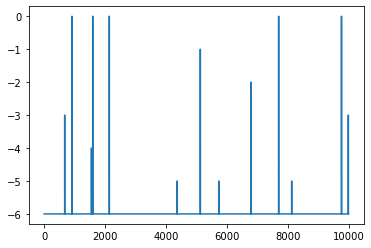

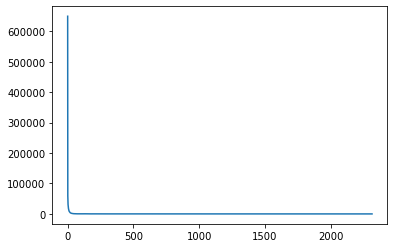

ABACK
ABACK
ABACK
ACRID
ABACK
AGLOW


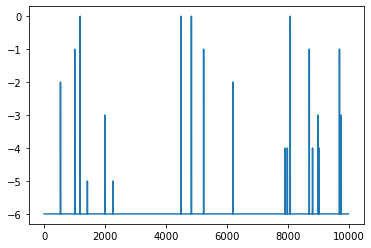

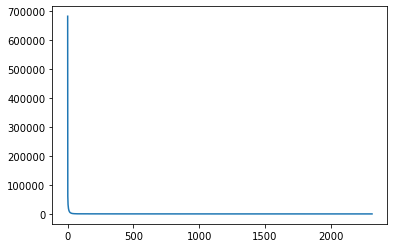

ABACK
ABACK
ABBEY
ACRID
ABACK
ARISE


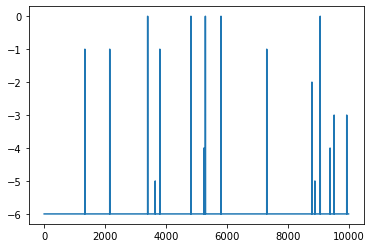

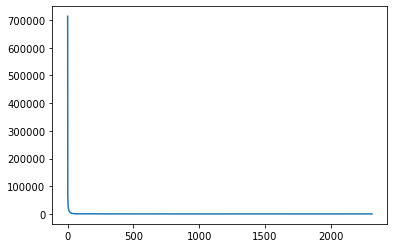

ABACK
ABACK
ABASE
ABIDE
ABACK
ALOUD


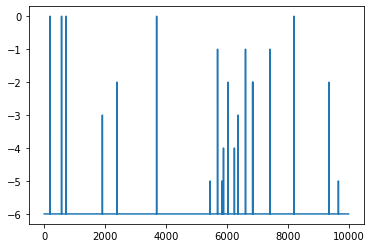

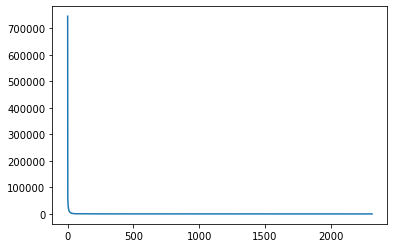

ABACK
ABBOT
ABACK
ABASE
AGAIN
ABACK


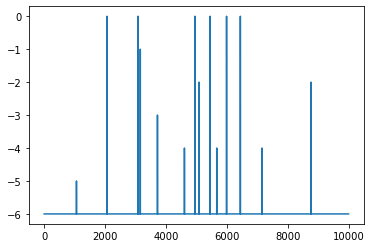

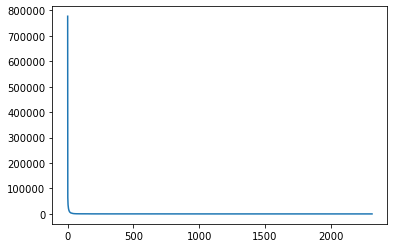

ABACK
ABACK
ABIDE
ABACK
ABACK
ABIDE


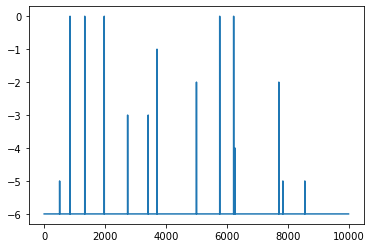

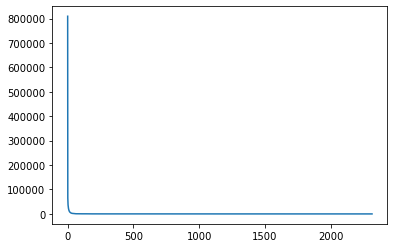

ABACK
ABACK
ABLED
ABACK
ADULT
BUSED


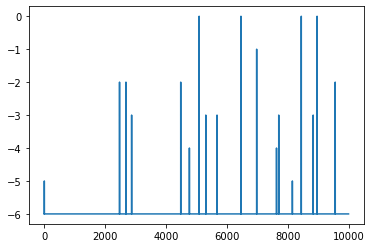

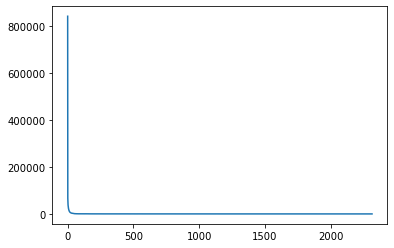

ABACK
ABORT
ABACK
ABOVE
ABACK
ABACK


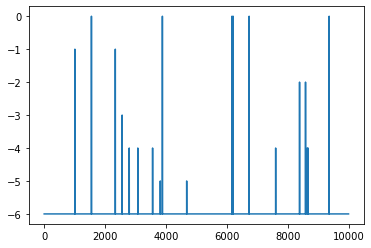

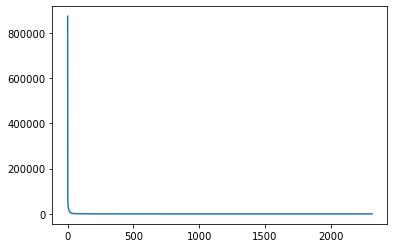

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


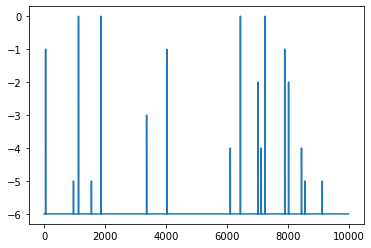

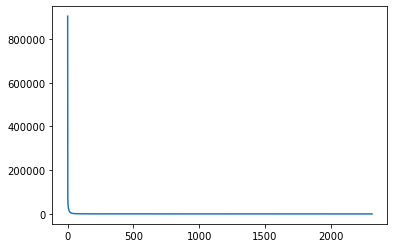

ABACK
ABOVE
ABODE
ADMIN
BONEY
LEGGY


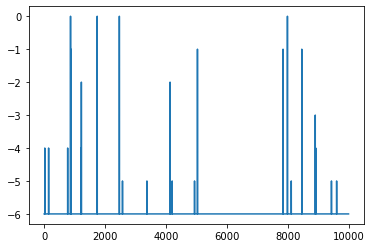

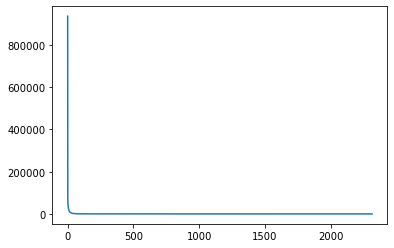

ABACK
ABORT
ABACK
ABASE
AGAIN
ADAPT


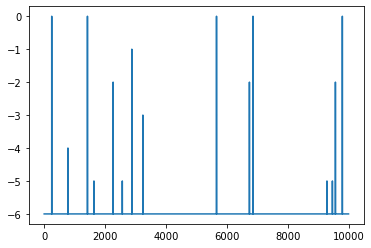

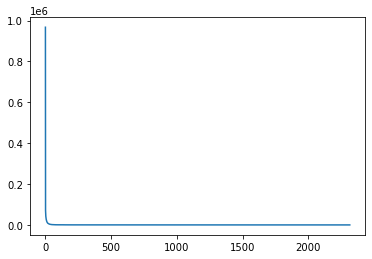

ABACK
ABHOR
ABACK
ABYSS
BERRY
FURRY


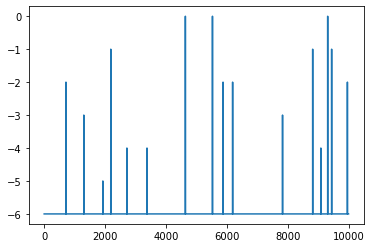

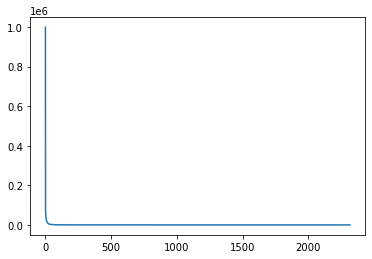

ABACK
ABACK
ABACK
ABACK
ABACK
AIDER


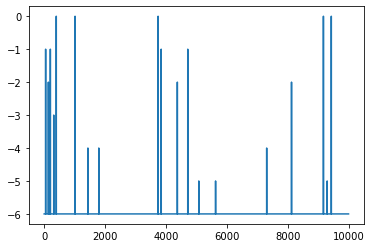

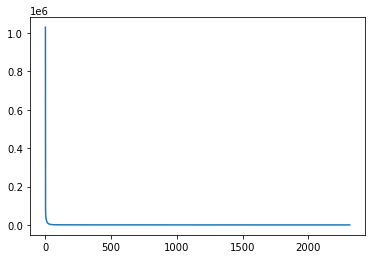

ABACK
ABACK
ABOVE
ABACK
AFFIX
ALPHA


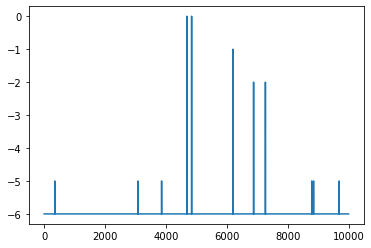

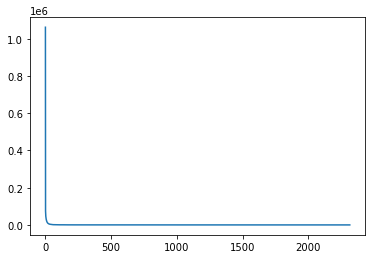

ABACK
ABATE
ACORN
ADORE
ERECT
NOBLY


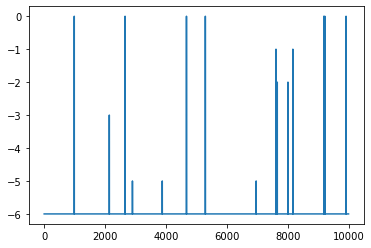

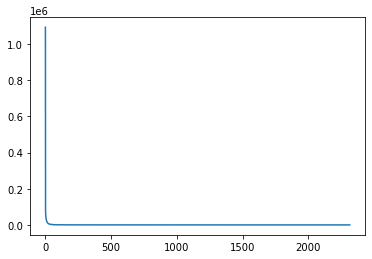

ABACK
ABASE
ACRID
AGONY
ENACT
MASSE


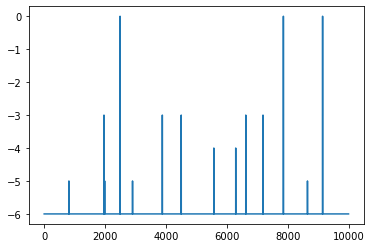

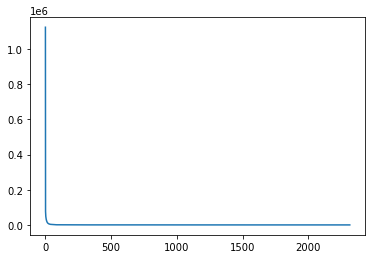

ABACK
ABACK
ABIDE
ACTOR
ARRAY
HEADY


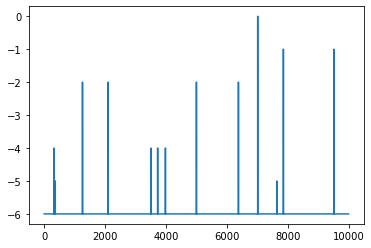

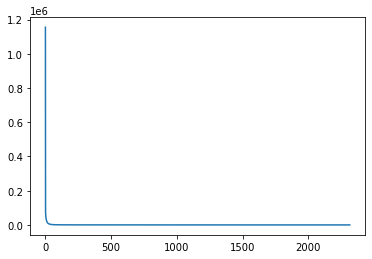

ABACK
ABACK
ABACK
ABACK
ABACK
ALOFT


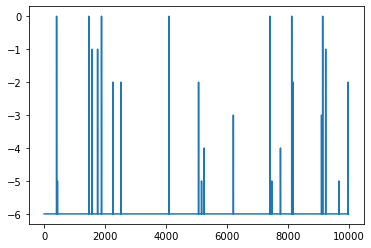

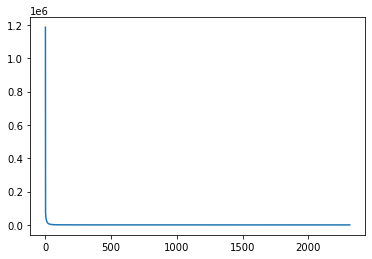

ABACK
ABACK
ABACK
ABACK
ADAGE
ABACK


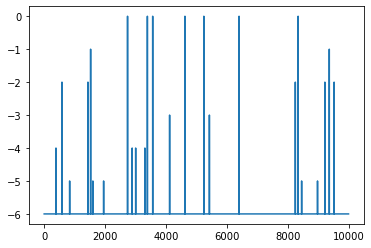

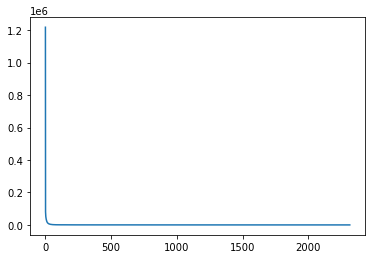

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


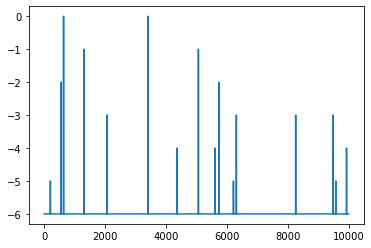

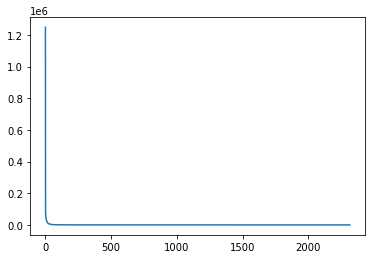

ABACK
ABACK
ABASE
ABACK
AFFIX
ABACK


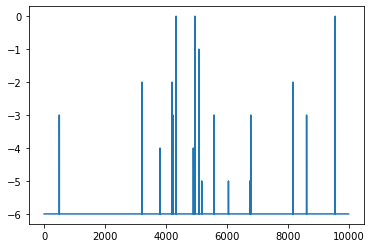

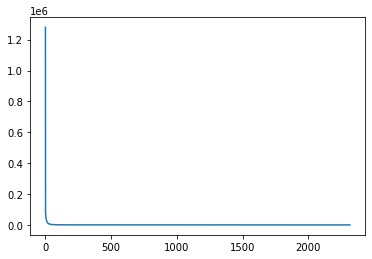

ABACK
ABOUT
ABACK
ADOBE
ABATE
ALLEY


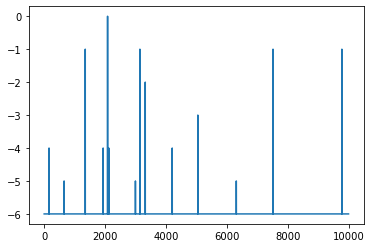

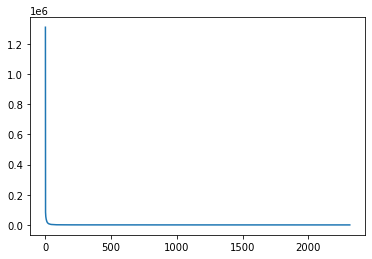

ABACK
ABACK
ABACK
ABACK
ABACK
AGATE


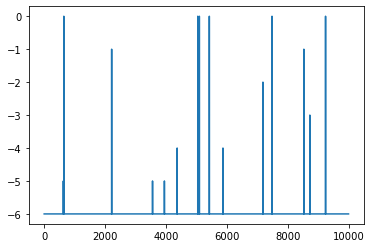

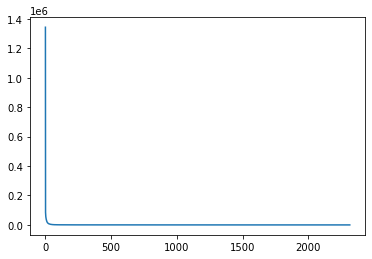

ABACK
ABACK
ABACK
ABODE
ABASE
AMONG


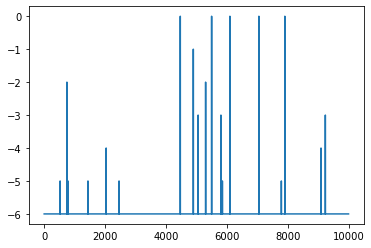

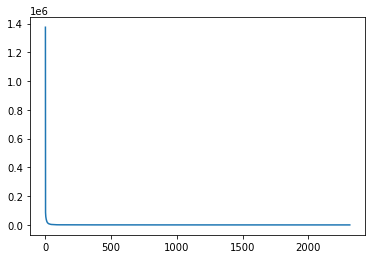

ABACK
ABACK
ABACK
ABORT
ABACK
BELCH


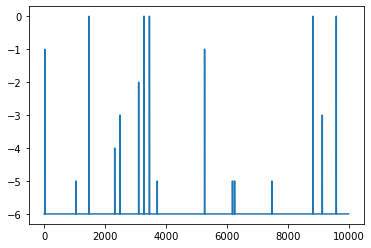

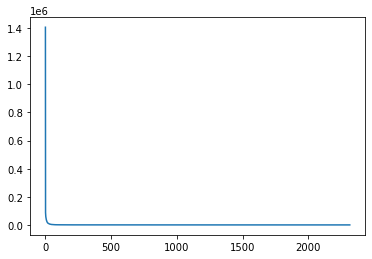

ABACK
ABATE
ABBOT
AGENT
AROMA
ELEGY


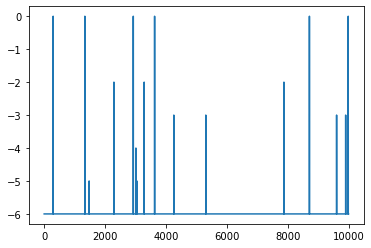

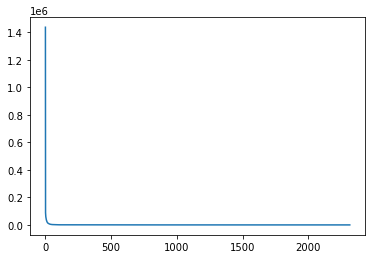

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


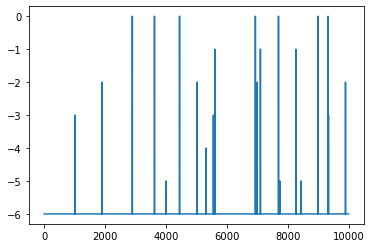

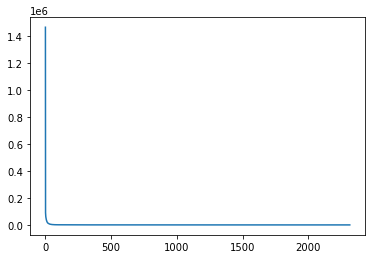

ABACK
ABACK
ABODE
ABACK
ABACK
ABOVE


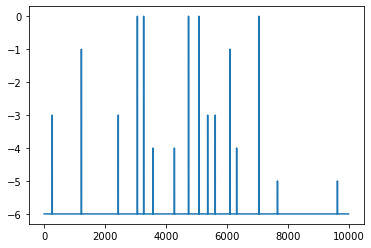

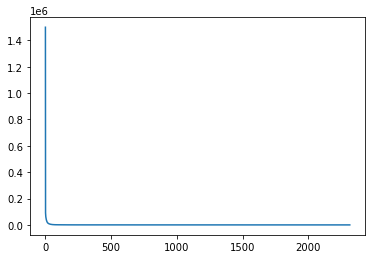

ABACK
ABACK
ABASE
ADORN
AWASH
FIXER


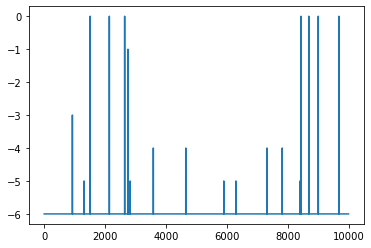

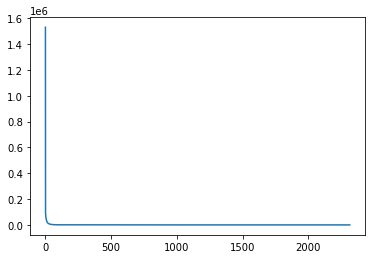

ABACK
ABOUT
AGREE
AGENT
BLOOM
MOTIF


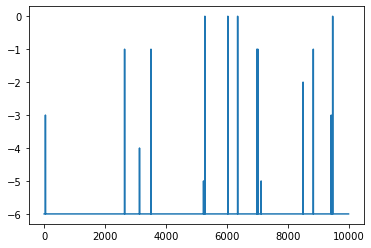

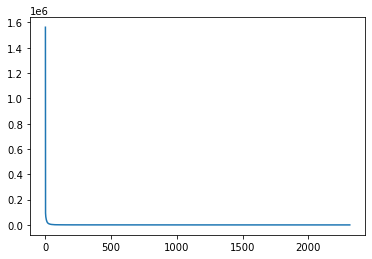

ABACK
ACORN
ABACK
ACRID
AGLOW
DREAM


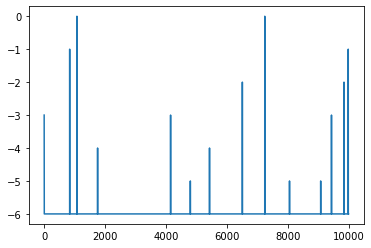

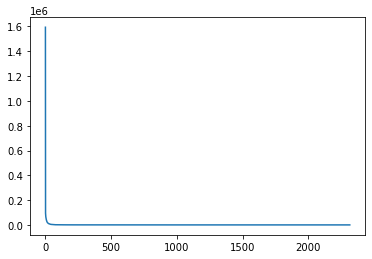

ABACK
ABACK
ABHOR
ABACK
ABACK
ABACK


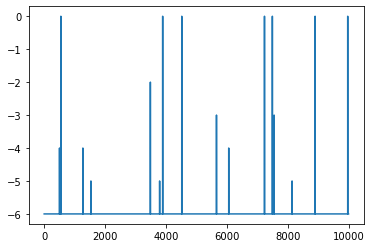

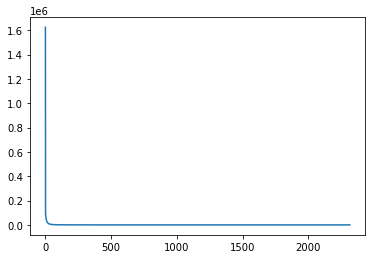

ABACK
ABATE
ABUSE
BASIS
GRAND
OLDEN


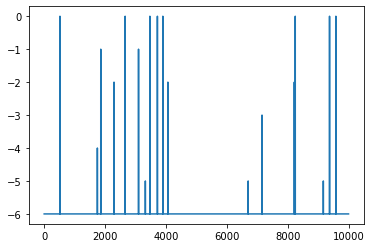

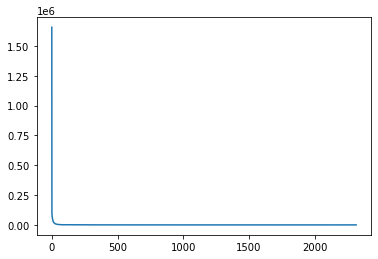

ABACK
ABIDE
ABACK
ABACK
ABACK
ABOUT


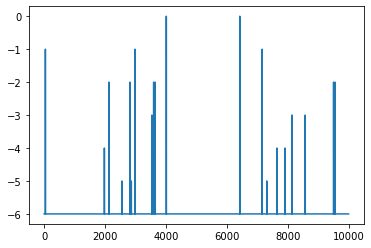

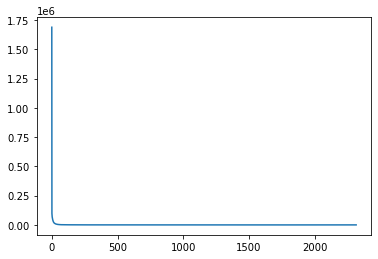

ABACK
ABODE
ABACK
ADEPT
ABACK
ABACK


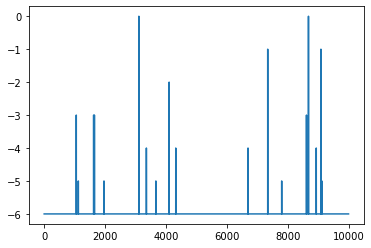

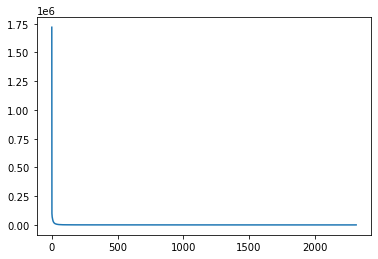

ABACK
ABORT
ABACK
AFFIX
ABIDE
BLEED


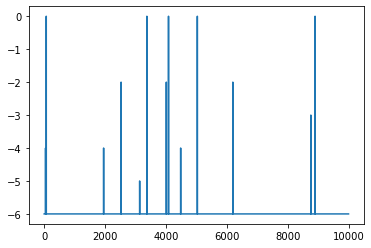

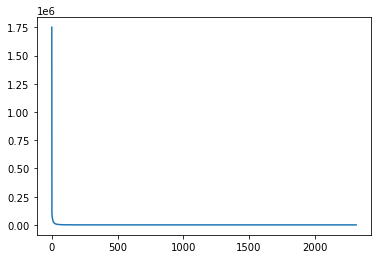

ABACK
ABACK
ABACK
ADORN
ABACK
ABACK


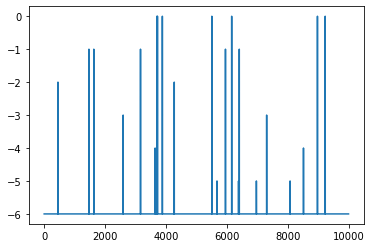

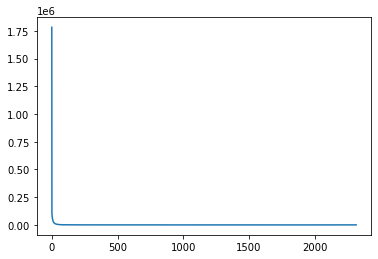

ABACK
ABASE
AFIRE
ADAGE
ANGEL
GUESS


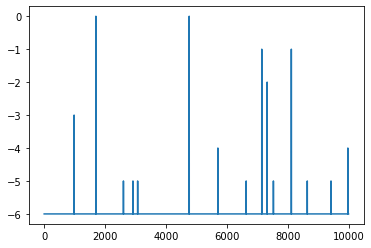

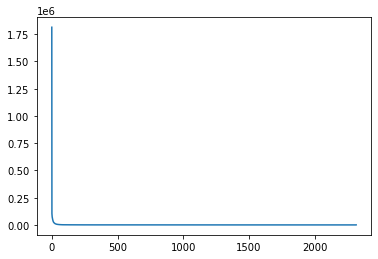

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


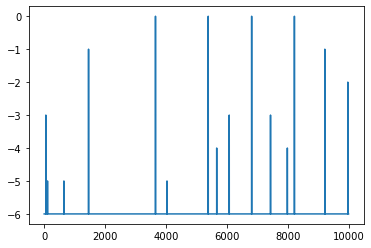

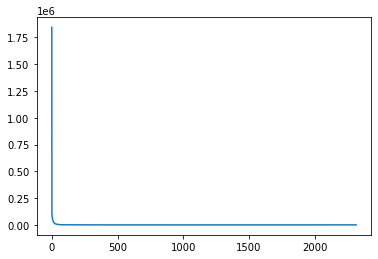

ABACK
ABACK
ABBEY
ABACK
ALBUM
ABACK


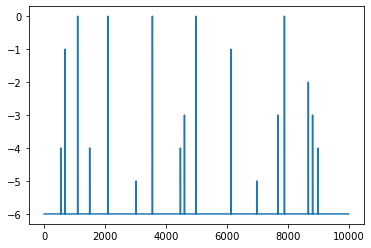

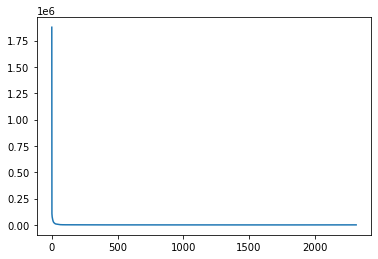

ABACK
ABACK
ABACK
AIDER
ALBUM
BIRCH


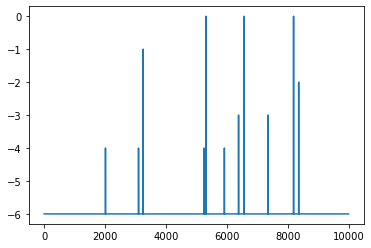

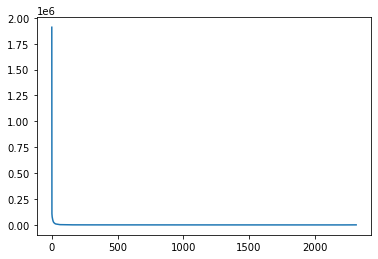

ABACK
ABATE
ABOUT
BILGE
DRILL
STINT


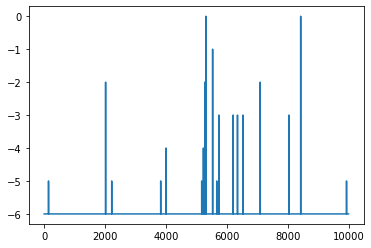

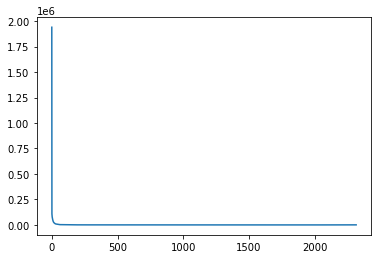

ABACK
ABACK
ABBOT
ABACK
ABACK
AFIRE


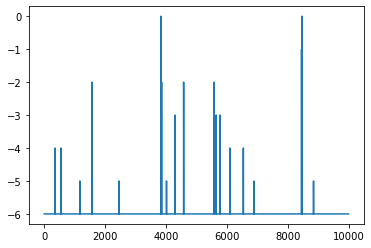

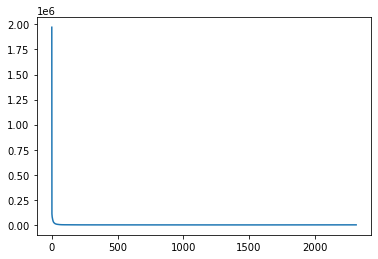

ABACK
ABATE
AGORA
BOOBY
MADLY
RUGBY


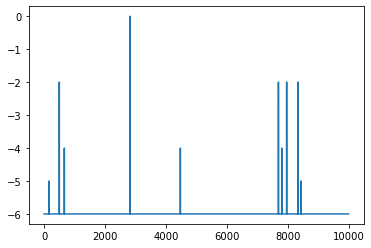

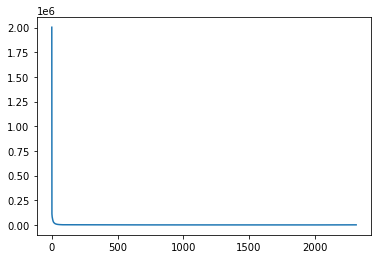

ABACK
ABIDE
ABACK
ABACK
ABACK
ABACK


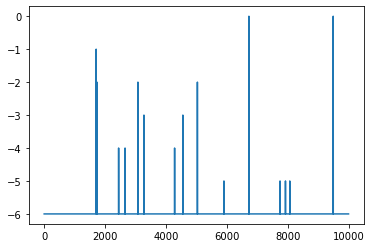

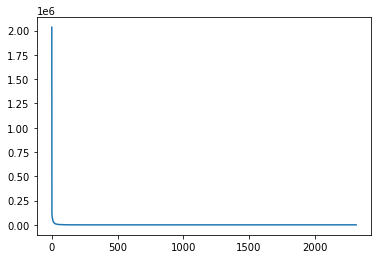

ABACK
ABATE
ABBOT
ABACK
ALTER
EMPTY


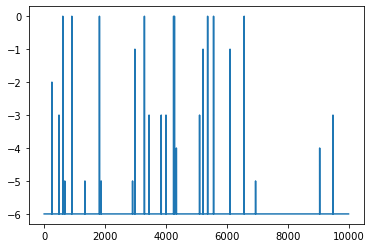

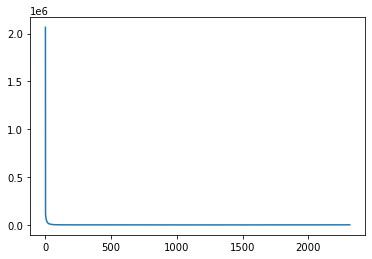

ABACK
ABACK
ABHOR
ADORN
BUNNY
SCRUM


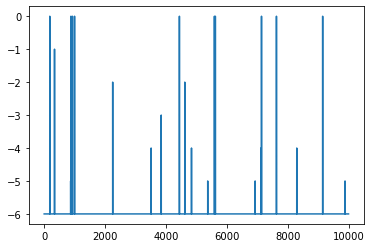

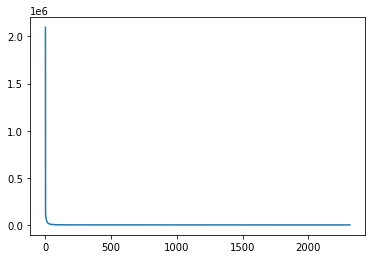

ABACK
ABBEY
ABOVE
ADMIN
BLOCK
ENDOW


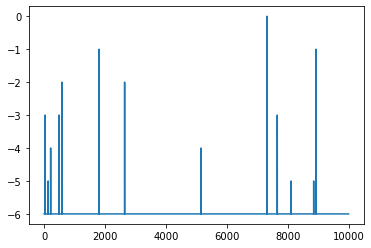

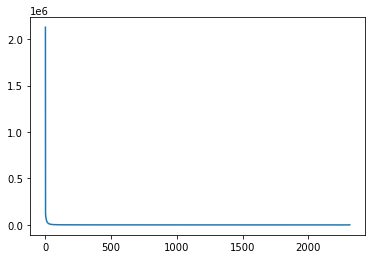

ABACK
ABACK
ABACK
ADMIT
ABACK
ALLOY


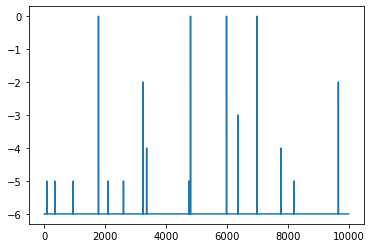

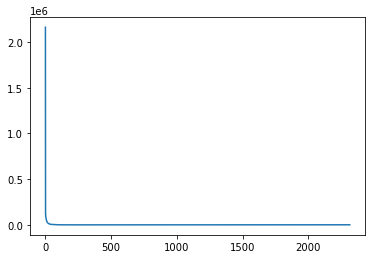

ABACK
ABACK
ABACK
ABACK
ABACK
ABACK


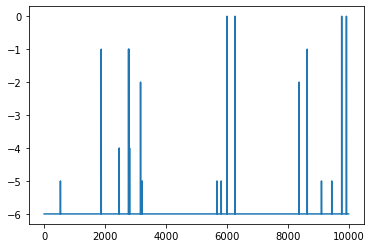

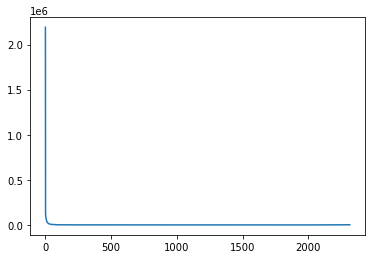

ABACK
ABBEY
ABACK
ABACK
ALBUM
BEACH


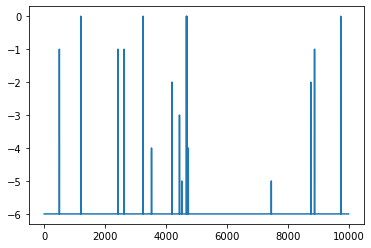

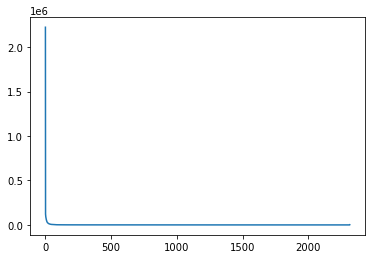

ABACK
ABATE
ABACK
ABATE
ABACK
ABACK


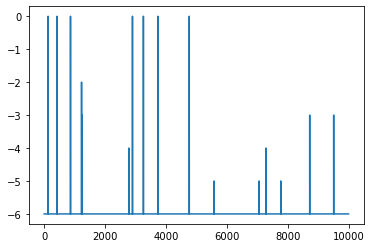

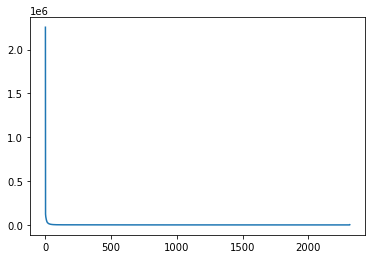

ABACK
ABACK
ABACK
ABOUT
AGLOW
CRUST


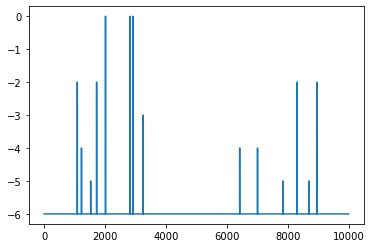

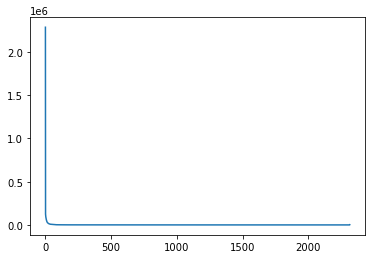

ABACK
ABACK
ABACK
ABOUT
ABACK
BATHE


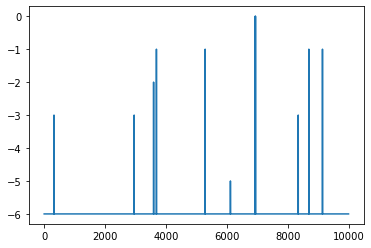

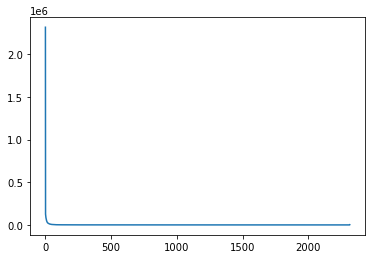

ABACK
ABACK
ABASE
AFIRE
ARSON
CORNY


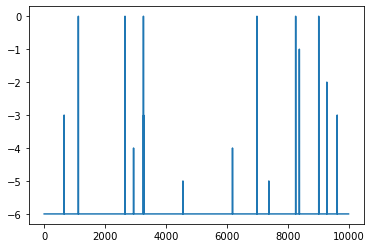

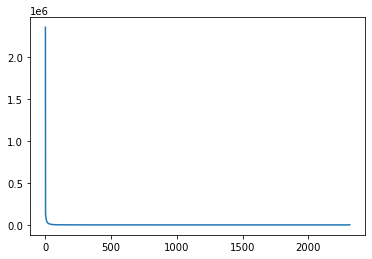

ABACK
ABASE
ABACK
ACTOR
BOWEL
SHACK


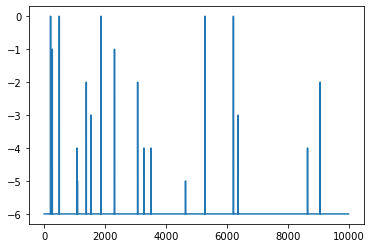

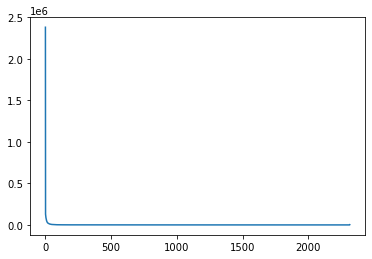

ABACK
ABATE
ADORE
AISLE
FABLE
SHOWN


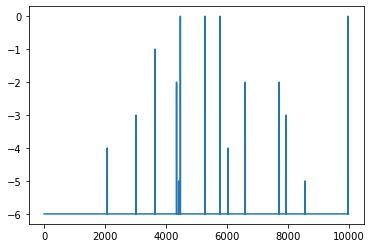

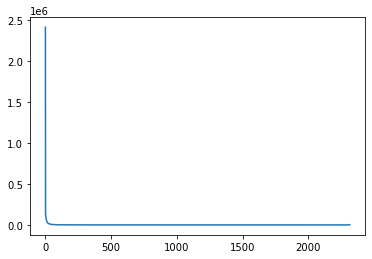

ABACK
ABACK
ABACK
ACUTE
ABACK
BLIND


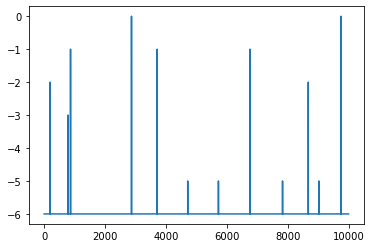

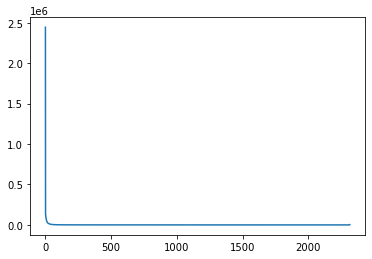

ABACK
ABIDE
ABACK
AFIRE
ABACK
ABACK


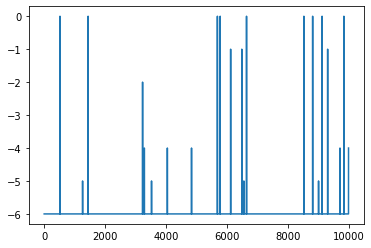

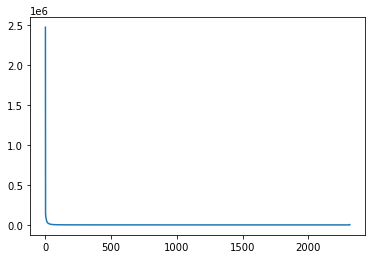

ABACK
ABACK
ABASE
ADAGE
ADAPT
     


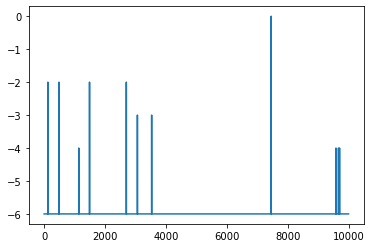

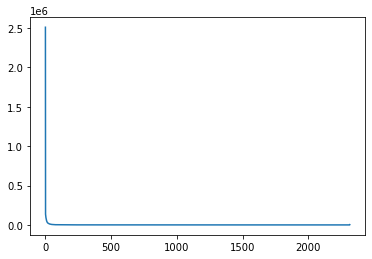

ABACK
ABACK
ABACK
ABLED
ABACK
ABACK


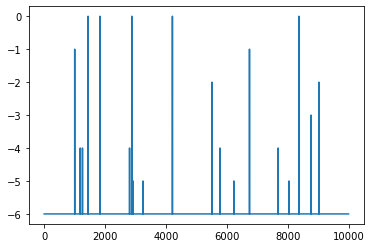

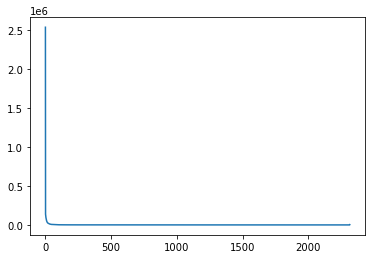

ABACK
ABACK
ABATE
ABOUT
ALIBI
NOISE


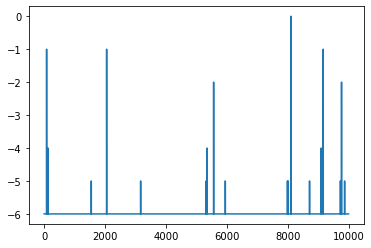

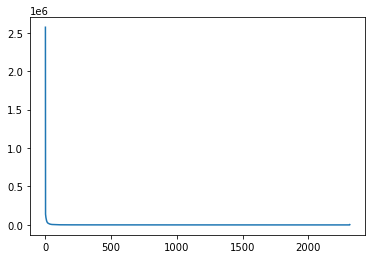

ABACK
ABLED
ACUTE
ALONG
NEWER
ZONAL


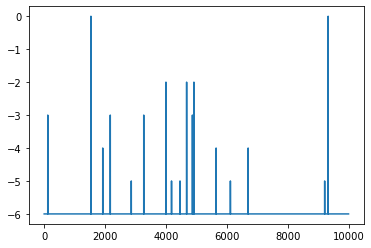

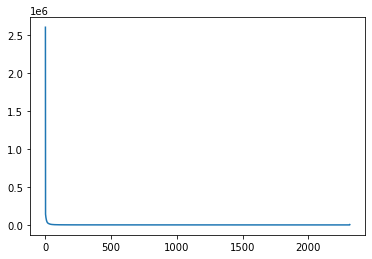

ABACK
ABACK
ABACK
ABATE
ABACK
ABACK


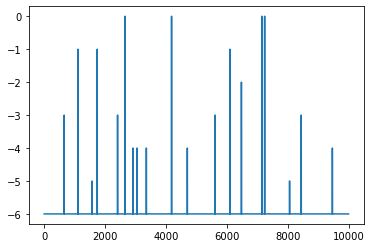

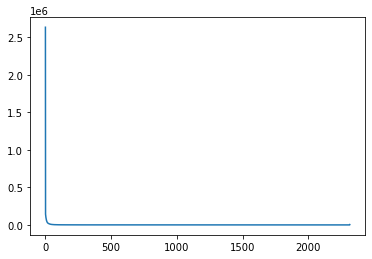

ABACK
ABATE
ACORN
AMAZE
DIRTY
ZONAL


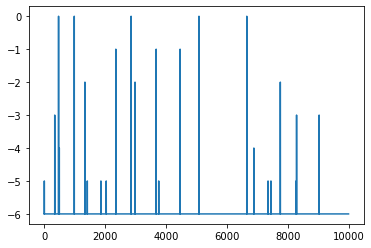

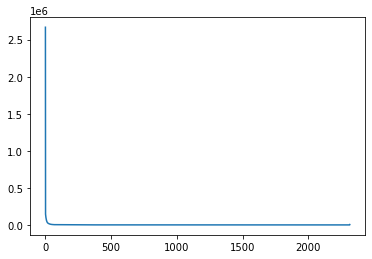

ABACK
ABACK
ABHOR
AIDER
ABACK
AISLE


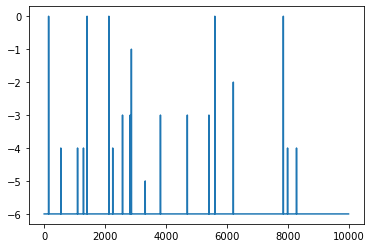

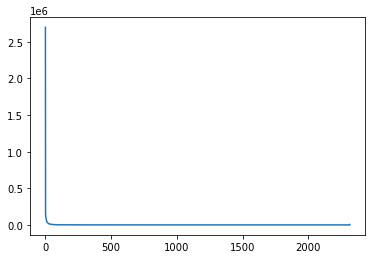

ABACK
ABACK
ABACK
ABOVE
ABACK
AROMA


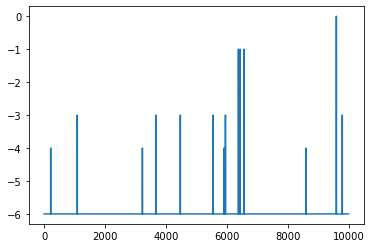

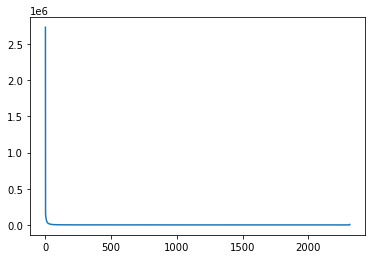

ABACK
ABBEY
ABASE
ABACK
ANGLE
ARRAY


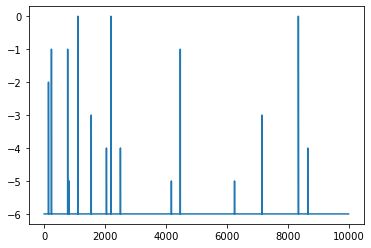

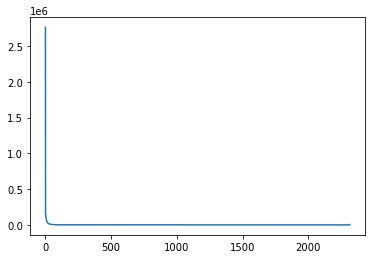

ABACK
ABACK
ABATE
ABATE
ADMIT
CACTI


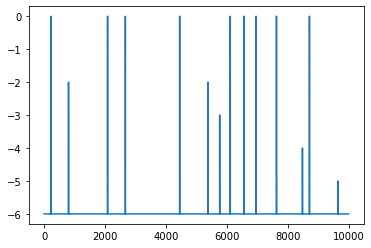

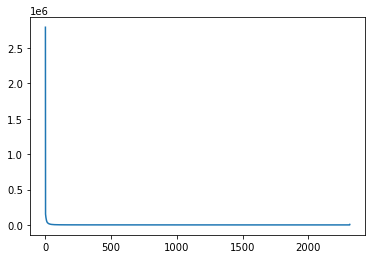

ABACK
ABASE
ABIDE
ABACK
ABACK
ABACK


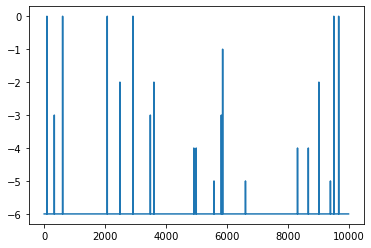

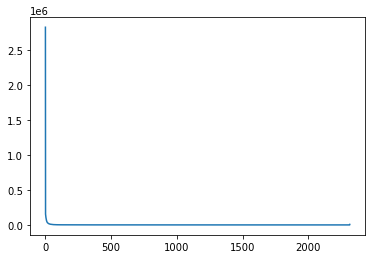

ABACK
ABATE
ABORT
ARBOR
FROST
ZONAL


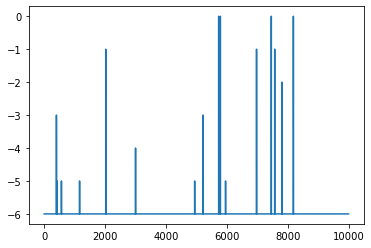

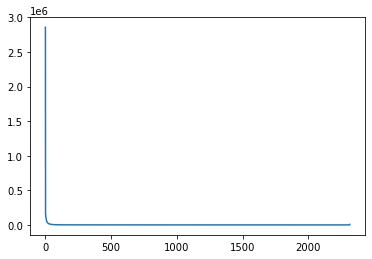

ABACK
ABACK
ABACK
ABUSE
ABACK
BREAD


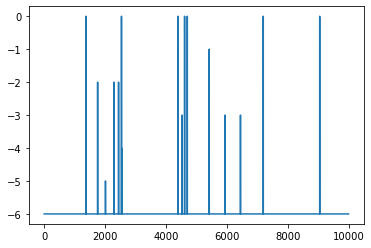

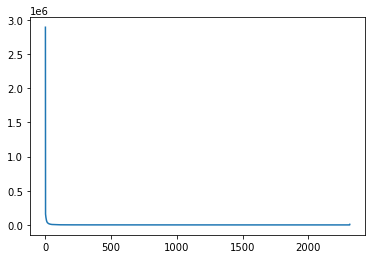

ABACK
ABACK
ABOVE
ABBEY
ALIVE
CRAWL


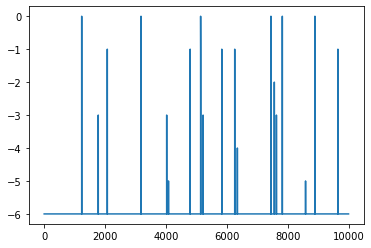

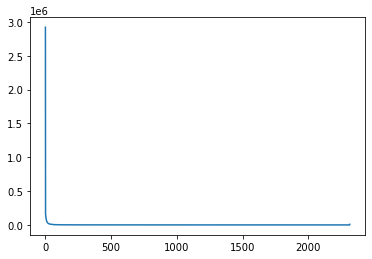

ABACK
ABBOT
ABACK
ACRID
ABACK
BADGE


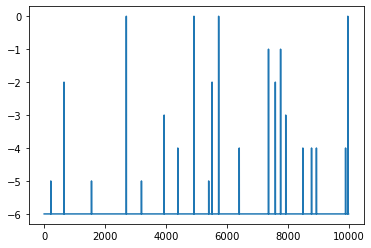

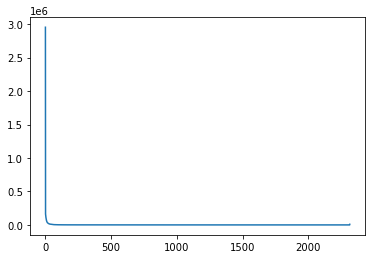

ABACK
ABACK
ABACK
ABOUT
ABACK
BROOK


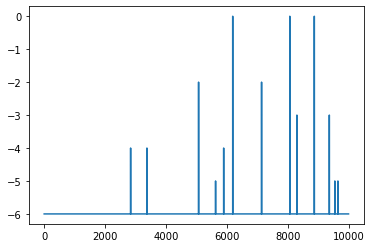

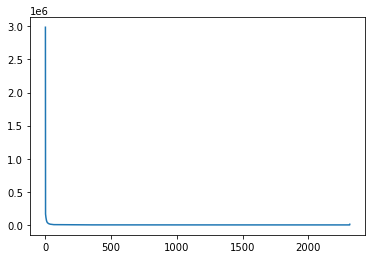

ABACK
ABASE
ABBOT
ABOUT
CHEAT
MINOR


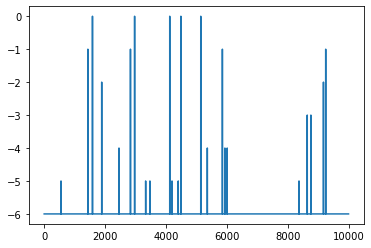

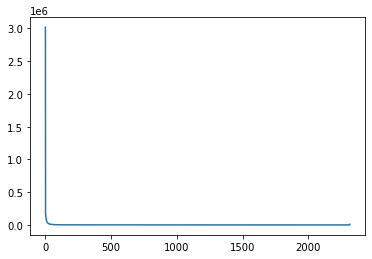

ABACK
ABACK
ABACK
ABACK
ABACK
ADMIN


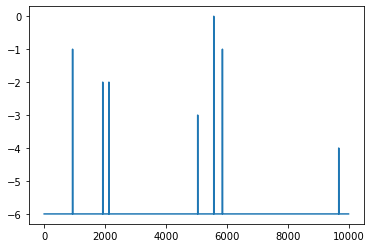

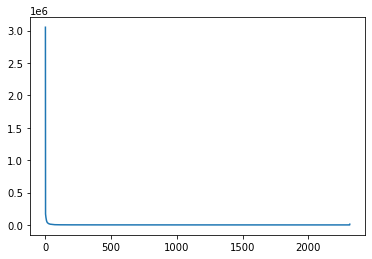

ABACK
ABACK
ABACK
ABACK
ADMIN
ALLAY


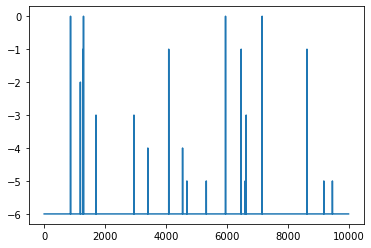

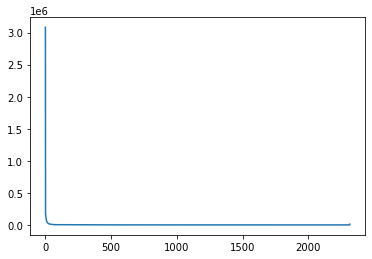

ABACK
ABASE
ABACK
ABACK
ABACK
AGORA


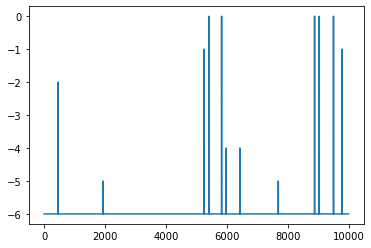

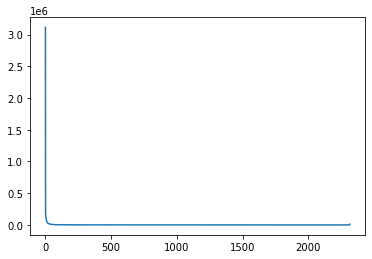

ABACK
ABATE
AGENT
APNEA
GRILL
ZONAL


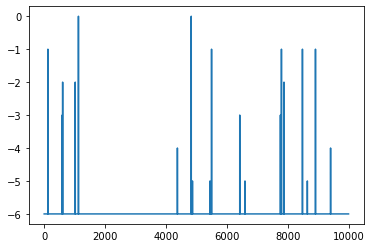

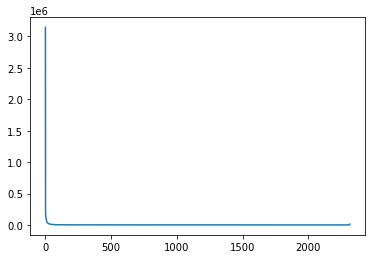

ABACK
ABACK
ABIDE
ABACK
ANGER
BLUNT


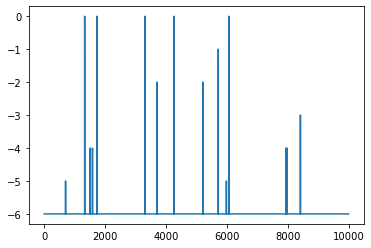

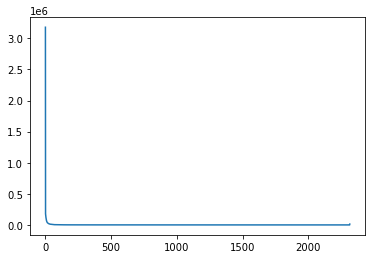

ABACK
ABACK
ABACK
ABASE
ABACK
ABACK


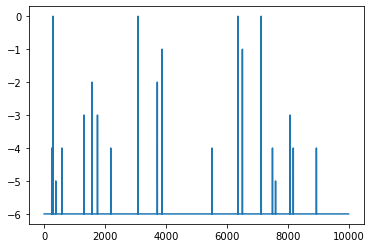

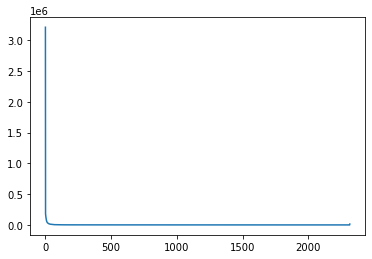

ABACK
ABBOT
ADMIN
ALERT
CIRCA
SAFER


In [8]:
for _ in range(100):
    agent.train(10000)
    plt.plot(agent.guesses)
    plt.show()
    agent.world.render()

In [63]:
agent.episode()
agent.world.render()

ABACK
ABBOT
ACUTE
BLOOD
LEDGE
UNCLE


In [64]:
torch.save(agent.actor.state_dict(), "long_train2.pt")